In [1]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def solveEquationPYPDE(variable, eq, ic="2*sech(x)", xrange=None, yrange=None, points=150, trange=pi/2):
    #initialize xrangenp.linspace(0, 10, 100).reshape(-1, 1)
    if xrange is None:
        xrange = [-5, 5]
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    eq.solve(field, t_range=trange, dt=1e-6*pi/2, tracker=[storage.tracker(0.01)])
    
    return field, storage

In [3]:
s1, st1 = solveEquationPYPDE('phi', f"0.5 * I * laplace(phi) + I * (phi*conjugate(phi)) * phi")

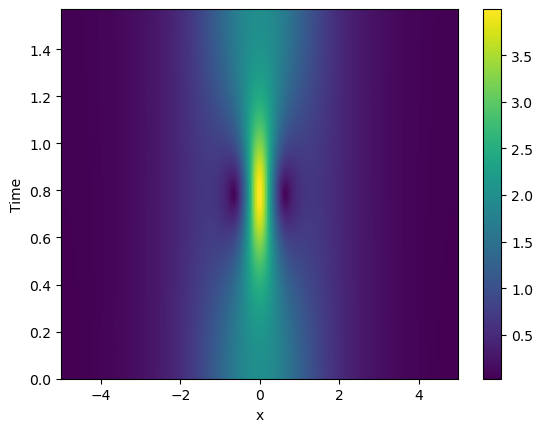

In [4]:
pde.plot_kymograph(st1)

In [5]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]
9
#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 105, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 100, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, u_train, v_train = gen_train(x_grid), gen_train(t_grid), gen_train(u), gen_train(v)

## attempt to plot
#plt.pcolormesh(x_train, t_train, np.sqrt(u_train**2 + v_train**2))


In [6]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

u_train = u_train.flatten()[:,None]
v_train = v_train.flatten()[:,None]

In [7]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

class PINN():
    def __init__(self, x, t, u, v, optim_name='adam', optim_steps=50000):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device)
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device)
        
        ##Maybe these two also need requires_grad = True!!
        self.u = torch.tensor(u, dtype=torch.float32, device=device)
        self.v = torch.tensor(v, dtype=torch.float32, device=device)
        
        self.null = torch.zeros((self.x.shape[0],1), device=device)

        self.net_init()

        self.optim_name = optim_name
        self.optim_steps = optim_steps
        
        if not self.optim_name or self.optim_name == 'adam':
            self.optim = torch.optim.Adam(self.net.parameters(), lr=3e-4)
        elif self.optim_name == 'lbfgs':
            self.optim = torch.optim.LBFGS(self.net.parameters(),
                                   lr=15,
                                   max_iter=self.optim_steps,
                                   #max_eval=self.optim_steps,
                                   history_size=20,
                                   tolerance_grad=-1,
                                   tolerance_change=-0.5 * np.finfo(float).eps,
                                   line_search_fn='strong_wolfe'
                                  )

        
        self.mse = torch.nn.MSELoss()
        self.ls = 0
        self.ls_arr = torch.zeros(self.optim_steps)
        
        self.step = 0
    
    def net_init(self, dDim=64, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, dDim),act(),
            #torch.nn.Linear(dDim, dDim),act(),
            torch.nn.Linear(dDim, 2)
        )
        self.net.to(device)
    
    def func(self, x, t):
        preds = self.net(torch.hstack((x, t)).contiguous())
        u, v = preds[:,0:1], preds[:,1:2]

        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]

        ## define the two parts of the function being approximated...
        ## ...only to be immediately fucked by autograd, thank you very much
        f_u = u_t + 0.5 * v_xx + (torch.square(u) + torch.square(v))*v 
        f_v = v_t - 0.5 * u_xx - (torch.square(u) + torch.square(v))*u

        return u, v, f_u, f_v
        
    def closure(self):
        self.optim.zero_grad(set_to_none=True)

        u_pred, v_pred, f_u_pred, f_v_pred = self.func(self.x, self.t)
        
        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_u_loss = self.mse(f_u_pred, self.null)
        f_v_loss = self.mse(f_v_pred, self.null)
        
        self.ls = u_loss + v_loss + f_u_loss + f_v_loss
        self.ls.backward()

        ## Show some graphs and stuff if step % 500 == 0
        if not self.step % 1000:
            print(f"Data loss u: {u_loss.item()}, Function loss u: {f_u_loss.item()}")
            print(f"Data loss v: {v_loss.item()}, Function loss v: {f_v_loss.item()}")
            print(f"Step: {self.step}, Loss: {self.ls}")
        self.ls_arr[self.step] = self.ls
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        if not self.optim_name or self.optim_name == 'adam':
            for i in range(self.optim_steps):
                self.optim.step(self.closure)
        elif self.optim_name == 'lbfgs':
            self.optim.step(self.closure)

In [8]:
pinn_adam = PINN(x_train, t_train, u_train, v_train,
                 optim_name = 'adam', optim_steps=20000)

#pinn_lbfgs = PINN(x_train, t_train, u_train, v_train,
#                  optim_name = 'lbfgs', optim_steps=10000)

In [9]:
pinn_adam.train()
#pinn_lbfgs.train()

Data loss u: 0.4915478825569153, Function loss u: 5.270041583571583e-05
Data loss v: 0.2915683686733246, Function loss v: 0.00015813576465006918
Step: 0, Loss: 0.783327043056488


/usr/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10500, 1], strides() = [1, 0]
param.sizes() = [10500, 1], strides() = [1, 0] (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Data loss u: 0.262267529964447, Function loss u: 0.016109365969896317
Data loss v: 0.25187695026397705, Function loss v: 0.01965034008026123
Step: 1000, Loss: 0.5499041676521301
Data loss u: 0.26022428274154663, Function loss u: 0.01644762046635151
Data loss v: 0.25148361921310425, Function loss v: 0.020174391567707062
Step: 2000, Loss: 0.5483298897743225
Data loss u: 0.25568729639053345, Function loss u: 0.015811719000339508
Data loss v: 0.24900563061237335, Function loss v: 0.021666377782821655
Step: 3000, Loss: 0.5421710014343262
Data loss u: 0.06337563693523407, Function loss u: 0.01242372952401638
Data loss v: 0.0588909387588501, Function loss v: 0.014154366217553616
Step: 4000, Loss: 0.1488446593284607
Data loss u: 0.014028421603143215, Function loss u: 0.01359278243035078
Data loss v: 0.012940528802573681, Function loss v: 0.013685106299817562
Step: 5000, Loss: 0.05424683913588524
Data loss u: 0.003469454823061824, Function loss u: 0.008010657504200935
Data loss v: 0.00362001755

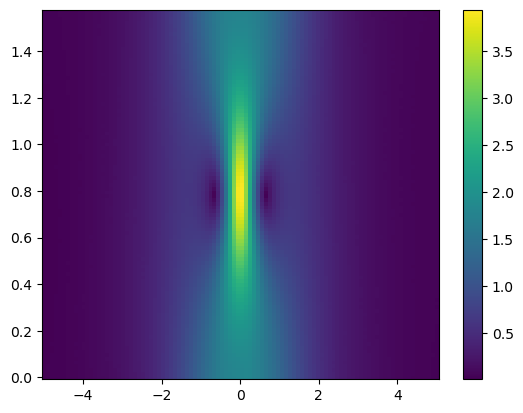

In [13]:
x_axis = torch.linspace(-5, 5, 100)
t_axis = torch.linspace(0, pi/2 ,100)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

preds_adam = pinn_adam.net(xt_pairs)
absval = torch.sqrt(preds_adam[:,0:1]**2 + preds_adam[:,1:2]**2).reshape((100,100)).cpu()

plt.pcolormesh(x_grid, t_grid, absval.detach())
plt.colorbar()
plt.show()

In [11]:
#preds_lbfgs = pinn_lbfgs.net(xt_pairs)
#absval_lbfgs = torch.sqrt(preds_lbfgs[:,0:1]**2 + preds_lbfgs[:,1:2]**2).reshape((100,100)).cpu()

#plt.pcolormesh(x_grid, t_grid, absval_lbfgs.detach())
#plt.colorbar()
#plt.show()

NameError: name 'pinn_lbfgs' is not defined

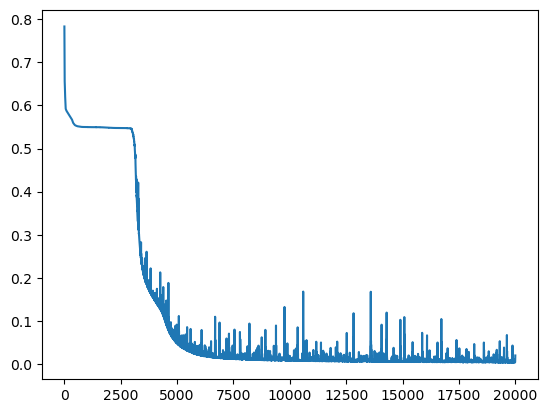

In [12]:
plt.plot(pinn_adam.ls_arr.detach(), label='ADAM')
plt.plot(pinn_lbfgs.ls_arr.detach(), label='LBFGS')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
pinn(torch.hstack((x_train.flatten())))

In [ ]:
np.hstack((x_train.flatten()[:,None], t_train.flatten()[:,None])).shape

In [ ]:
## CHECK IF THE TRAINING DATA IS ALIGNED

xx = x_train.flatten()
tt = t_train.flatten()
z = (np.sqrt(u_train**2 + v_train**2)).flatten()

ax = plt.axes(projection='3d')
ax.view_init(90, -90, 0)
ax.plot_trisurf(xx, tt, z, cmap='jet')

In [ ]:
print(x_train.shape, t_train.shape, u_train.shape, v_train.shape)